In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error

In [2]:
#load data
data=pd.read_csv('TataGlobal.csv')

In [3]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
data.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


In [5]:
df1=data.reset_index()['Close']

In [6]:
df1.shape

(2035,)

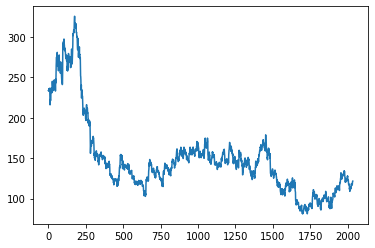

In [7]:
plt.plot(df1)

In [9]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
df1.shape

(2035, 1)

In [11]:
df1

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

In [12]:
#Split the data into train and test split
training_size = int(len(df1) * 0.75)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [14]:
#data preprocessing
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [16]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [17]:
#Create the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 16s 351ms/step - loss: 0.0303 - val_loss: 0.0061
Epoch 2/100
23/23 [==============================] - 7s 296ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 3/100
23/23 [==============================] - 7s 305ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 4/100
23/23 [==============================] - 8s 329ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 5/100
23/23 [==============================] - 7s 293ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 6/100
23/23 [==============================] - 8s 324ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 7/100
23/23 [==============================] - 7s 286ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 8/100
23/23 [==============================] - 7s 307ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/100
23/23 [==============================] - 8s 329ms/step - loss: 0.0012 - val_loss: 7.9661e-04
Epoch 10/100
23/23 [==============================] - 7s 302ms/step - loss: 0.0012 - v

In [20]:
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [22]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [23]:
#Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train, train_predict))

0.013712790623674241

In [24]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

0.012154854544283398

In [25]:
#Plotting
#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

In [26]:
#Shift test prediction for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df1) - 1, :] = test_predict

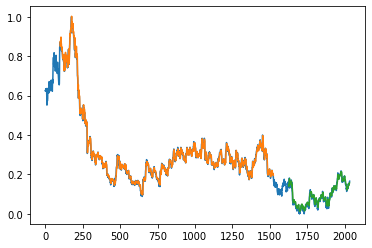

In [27]:
#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()